In [1]:
!hostname

gnode009.cluster


In [2]:
!nvidia-smi

Thu Sep 14 08:54:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:98:00.0 Off |                    0 |
| N/A   27C    P0    63W / 300W |  12632MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)
import time

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


(400, 400) (400, 400) (400, 400)
(400, 400, 2)
CPU times: user 33.9 ms, sys: 3.46 ms, total: 37.4 ms
Wall time: 42 ms


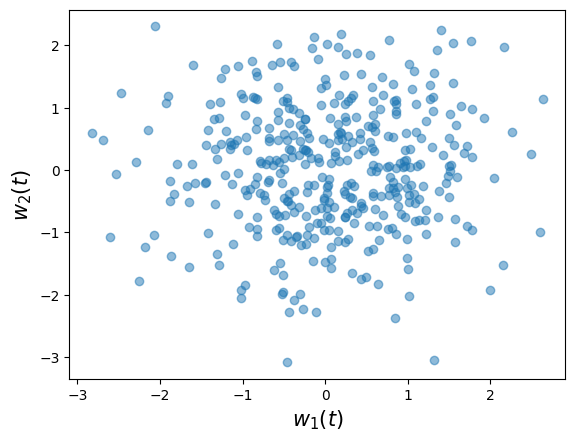

In [7]:
%%time

#### Generating SINN training data by solving SDE (Langevin dynamics)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad


#### Parameters 
batch = 400                            # Batch size 
sec_length = 400                       # Length of the input sequence 



# Construct the sample traj for SINN learning 
ini=np.random.randn(sec_length,batch)
w1=np.random.randn(sec_length,batch)
w2=np.random.randn(sec_length,batch)
print(ini.shape, w1.shape, w2.shape)

plt.scatter(w1[:,0], w2[:,0], alpha=0.5)
plt.xlabel(r'$w_1(t)$',fontsize=15)
plt.ylabel(r'$w_2(t)$',fontsize=15)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = w1
Traj[:,:,1] = w2
T=np.arange(len(w1[:,1]))
x=np.linspace(-5,5,sec_length)
print(Traj.shape)

In [8]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 1), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


(array([-6., -4., -2.,  0.,  2.,  4.,  6.]),
 [Text(0, -6.0, '−6'),
  Text(0, -4.0, '−4'),
  Text(0, -2.0, '−2'),
  Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6')])

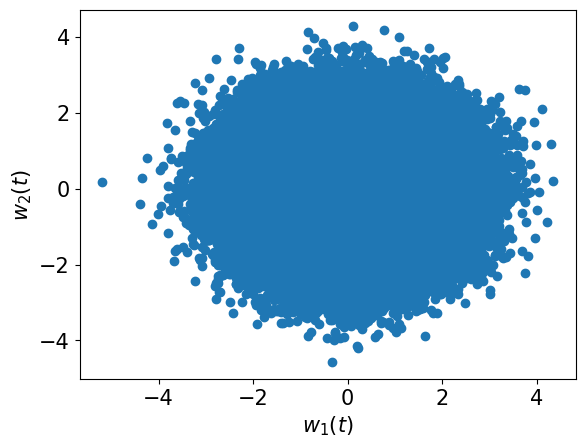

In [9]:
plt.scatter(Traj[:,:,0], Traj[:,:,1])
plt.xlabel(r'$w_1(t)$',fontsize=15)
plt.ylabel(r'$w_2(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [10]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical1 = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2 = make_loss('pdf2', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2D = make_loss('pdf2D', target, lower=-5, upper=5, n=20, bw=None, device=device)

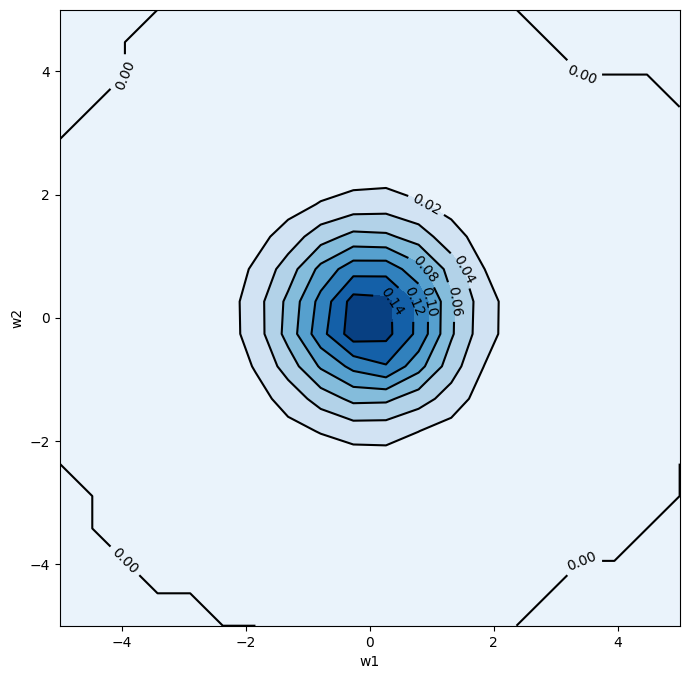

In [11]:
xmin, xmax = -5, 5
ymin, ymax = -5, 5

xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# plt.contour(loss_pdf_empirical._target.cpu())
# Contourf plot
cfset = ax.contourf(xx, yy, loss_pdf_empirical2D._target.cpu(), cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, loss_pdf_empirical2D._target.cpu(), colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('w1')
ax.set_ylabel('w2')

plt.show()

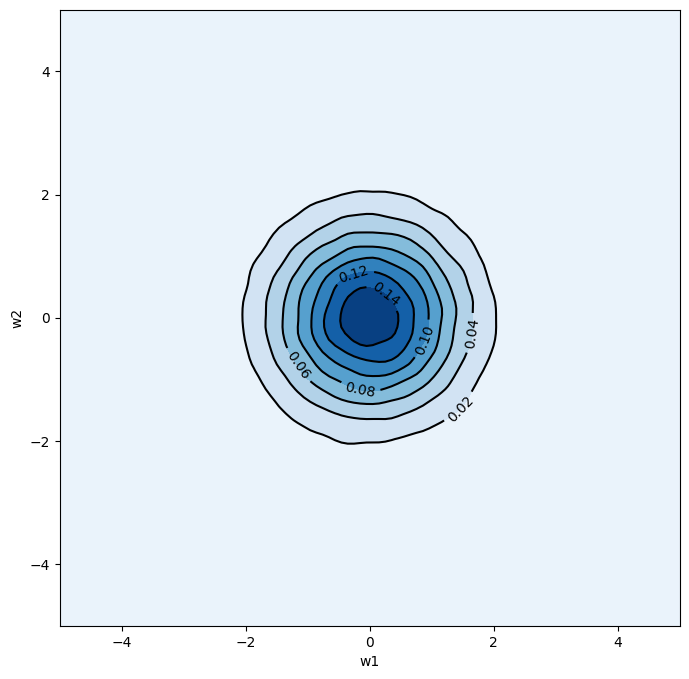

In [12]:
import scipy.stats as st

x = Traj[..., 0].ravel()
y = Traj[..., 1].ravel()
xmin, xmax = -5, 5
ymin, ymax = -5, 5

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('w1')
ax.set_ylabel('w2')

plt.show()

torch.Size([400, 2])


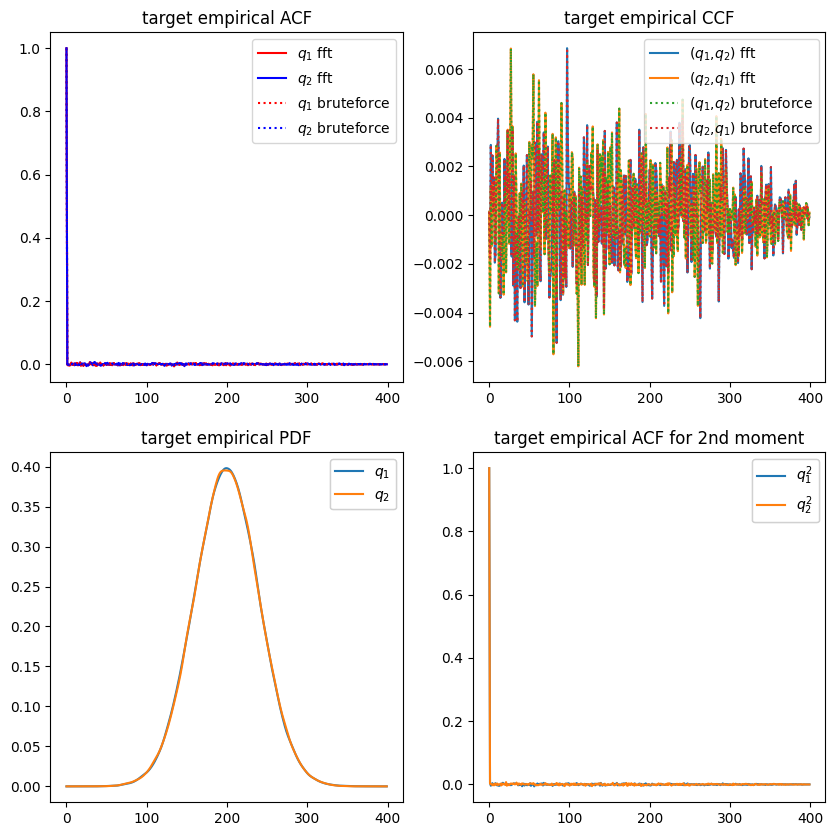

In [13]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_1$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,-1],'b', label=r'$q_2$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_1$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_2$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,0], label=r'($q_1$,$q_2$) fft')
axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1], label=r'($q_2$,$q_1$) fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,0],':',label=r'($q_1$,$q_2$) bruteforce')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1],':',label=r'($q_2$,$q_1$) bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical1._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_1$', r'$q_2$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_1^2$', r'$q_2^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

Text(0.5, 1.0, 'target empirical PDF')

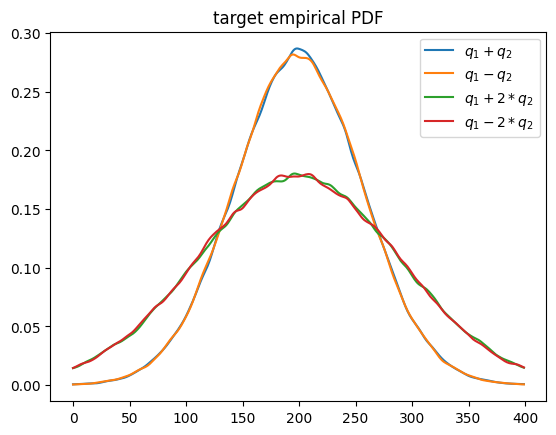

In [14]:
x_grid=-np.linspace(-5,5,num=sec_length)
plt.plot(loss_pdf_empirical2._target.cpu()[...,0],label=r'$q_1+q_2$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,1],label=r'$q_1-q_2$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,2],label=r'$q_1+2*q_2$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,3],label=r'$q_1-2*q_2$')
plt.legend()
# plt.add_artist(legend3)
plt.title('target empirical PDF')

In [15]:
class Model:
    def __init__(self, net):

        self.x_acf_s = None
        self.x_ccf_s = None
        self.x_pdf_s = None
        self.x_pdf2_s = None
        self.x_acf2_s = None
        self.s_collect = []

        self.net = net

        self.T_error=[]
        self.V_error=[]
        self.T_ccf=[]
        self.V_ccf=[]
        self.T_pdf=[]
        self.V_pdf=[]
        self.T_pdf2=[]
        self.V_pdf2=[]
        self.T_acf=[]
        self.V_acf=[]
        self.T_acf2=[]
        self.V_acf2=[]
        self.Step=[]
        self.iter = 0

    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)

    def likelihood_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        loss = torch.exp(-self.x_acf_s) * loss_acf.detach() + self.x_acf_s \
               + torch.exp(-self.x_ccf_s) * loss_ccf.detach() + self.x_ccf_s \
               + torch.exp(-self.x_pdf_s) * loss_pdf.detach() + self.x_pdf_s \
               + torch.exp(-self.x_pdf2_s) * loss_pdf2.detach() + self.x_pdf2_s \
               + torch.exp(-self.x_acf2_s) * loss_acf2.detach() + self.x_acf2_s
        return loss

    def true_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        return torch.exp(-self.x_acf_s.detach()) * loss_acf + torch.exp(-self.x_ccf_s.detach()) * loss_ccf + torch.exp(-self.x_pdf_s.detach()) * loss_pdf + torch.exp(-self.x_pdf2_s.detach()) * loss_pdf2 + torch.exp(-self.x_acf2_s.detach()) * loss_acf2


    def run_baseline(self):
        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        for step in range(20000):
            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val)+ loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.6f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if acf <=0.0001 and ccf <=0.00001 and pdf<=0.00002 and pdf2<=0.00002 and acf_sec_moment<=0.0001:
                break

        if acf > 0.0001 or ccf > 0.00001 or pdf >0.00002 or pdf2 >0.00002 or acf_sec_moment>0.0001:
            print ('Training failed')
        print('Training finished')



    def run_AW(self):
        self.x_acf_s = nn.Parameter(self.x_acf_s, requires_grad=True)
        self.x_ccf_s = nn.Parameter(self.x_ccf_s, requires_grad=True)
        self.x_pdf_s = nn.Parameter(self.x_pdf_s, requires_grad=True)
        self.x_pdf2_s = nn.Parameter(self.x_pdf_s, requires_grad=True)
        self.x_acf2_s = nn.Parameter(self.x_acf2_s, requires_grad=True)


        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        optimizer_adam_weight = optim.Adam([self.x_acf_s] + [self.x_ccf_s] + [self.x_pdf_s] + [self.x_pdf2_s] + [self.x_acf2_s],
                                                     lr=1e-3)

        for step in range(20000):
            self.s_collect.append([self.iter, self.x_acf_s.item(), self.x_ccf_s.item(), self.x_pdf_s.item(), self.x_pdf2_s.item(), self.x_acf2_s.item()])

            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val) + loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.6f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if acf <=0.0001 and ccf <=0.00001 and pdf<=0.00002 and pdf2<=0.00004 and acf_sec_moment<=0.0001:
                break
            optimizer_adam_weight.zero_grad()
            loss = self.likelihood_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam_weight.step()
            
        if acf > 0.0001 or ccf > 0.00001 or pdf >0.00002 or pdf2 >0.00004 or acf_sec_moment>0.0001:
            print ('Training failed')
        print('Training finished')


    def train(self):
        self.x_acf_s = torch.tensor(0.).float()
        self.x_ccf_s = torch.tensor(0.).float()
        self.x_pdf_s = torch.tensor(2.).float()
        self.x_pdf2_s = torch.tensor(2.).float()
        self.x_acf2_s = torch.tensor(2.).float()
        start_time = time.time()
        if model_type == 0:
            self.run_baseline()
        elif model_type == 1:
            self.run_AW()
        elapsed = time.time() - start_time
        print('Training time: %.2f' % elapsed)

In [16]:
### Defining SINN model
net = SINN(1, 10, 2, 2).to(device)
model = Model(net=net)

model_type = 1 # 0: baseline 1: AW

In [17]:
model.train()

[0]-th step loss: 0.5505, 0.5495, acf: 0.00450, ccf: 0.006942, pdf: 0.25741, pdf2: 0.27620, acf2: 0.00445
[50]-th step loss: 0.5333, 0.5330, acf: 0.00043, ccf: 0.001968, pdf: 0.25677, pdf2: 0.27349, acf2: 0.00032
[100]-th step loss: 0.3993, 0.3904, acf: 0.00117, ccf: 0.001499, pdf: 0.21723, pdf2: 0.16959, acf2: 0.00089
[150]-th step loss: 0.0606, 0.0588, acf: 0.00416, ccf: 0.001890, pdf: 0.03862, pdf2: 0.01223, acf2: 0.00187
[200]-th step loss: 0.0188, 0.0183, acf: 0.00224, ccf: 0.001632, pdf: 0.00922, pdf2: 0.00433, acf2: 0.00090
[250]-th step loss: 0.0096, 0.0095, acf: 0.00153, ccf: 0.001075, pdf: 0.00411, pdf2: 0.00213, acf2: 0.00062
[300]-th step loss: 0.0058, 0.0057, acf: 0.00108, ccf: 0.000845, pdf: 0.00213, pdf2: 0.00127, acf2: 0.00041
[350]-th step loss: 0.0039, 0.0038, acf: 0.00083, ccf: 0.000694, pdf: 0.00120, pdf2: 0.00080, acf2: 0.00030
[400]-th step loss: 0.0029, 0.0028, acf: 0.00069, ccf: 0.000594, pdf: 0.00074, pdf2: 0.00056, acf2: 0.00023
[450]-th step loss: 0.0023, 0.0

In [18]:
def draw_loss(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.loglog(model.Step, model.T_error,'r',label='Training error')
    plt.loglog(model.Step, model.V_error,'b--',label='Validation error')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)

In [19]:
def draw_errors(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
    plt.loglog(model.Step, model.T_error,'k',label='Training error')
    plt.loglog(model.Step, model.V_error,'k--')
    plt.loglog(model.Step, model.T_acf,'r',label='acf error')
    plt.loglog(model.Step, model.V_acf,'r--')
    plt.loglog(model.Step, model.T_ccf,'b',label='ccf error')
    plt.loglog(model.Step, model.V_ccf,'b--')
    plt.loglog(model.Step, model.T_pdf,'y',label='pdf error')
    plt.loglog(model.Step, model.V_pdf,'y--')
    plt.loglog(model.Step, model.T_pdf2,'p',label='pdf2 error')
    plt.loglog(model.Step, model.V_pdf2,'p--')
    plt.loglog(model.Step, model.T_acf2,'g',label='acf2 error')
    plt.loglog(model.Step, model.V_acf2,'g--')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [20]:
def draw_epoch_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
    plt.yscale('log')
    plt.plot(s_collect[:, 0], np.exp(-s_collect[:, 1]), 'r-', label=r'$e^{-s_{acf}}$')
    plt.plot(s_collect[:, 0], np.exp(-s_collect[:, 2]), 'b-', label='$e^{-s_{ccf}}$')
    plt.plot(s_collect[:, 0], np.exp(-s_collect[:, 3]), 'y-', label='$e^{-s_{pdf}}$')
    plt.plot(s_collect[:, 0], np.exp(-s_collect[:, 4]), 'p-', label='$e^{-s_{pdf2}}$')
    plt.plot(s_collect[:, 0], np.exp(-s_collect[:, 5]), 'g-', label='$e^{-s_{acf2}}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$\lambda$')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

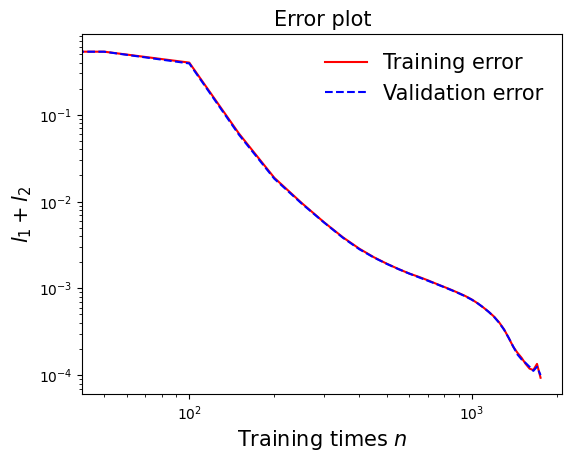

In [21]:
draw_loss(model)

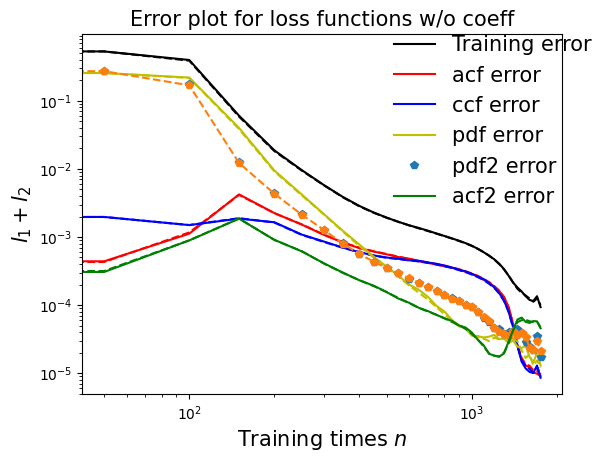

In [22]:
draw_errors(model)

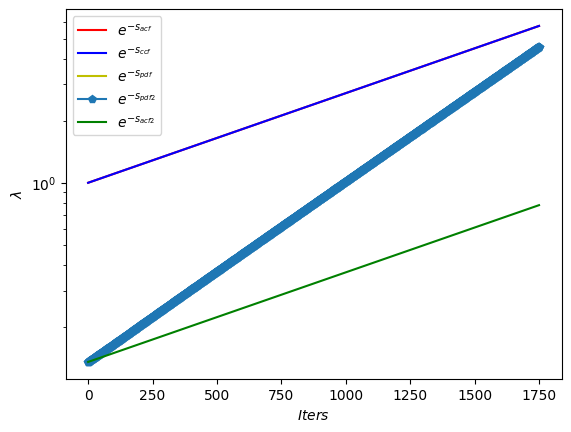

In [23]:
draw_epoch_w(model)

In [24]:
def test1(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:20]-T[skip], Traj[skip:20, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$w_1(t)$ and $w_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:20]-T[skip], prediction[skip:20, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$w_1(t)$ and $w_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

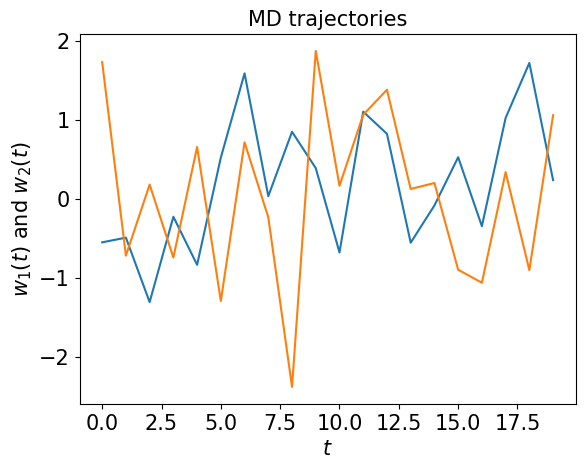

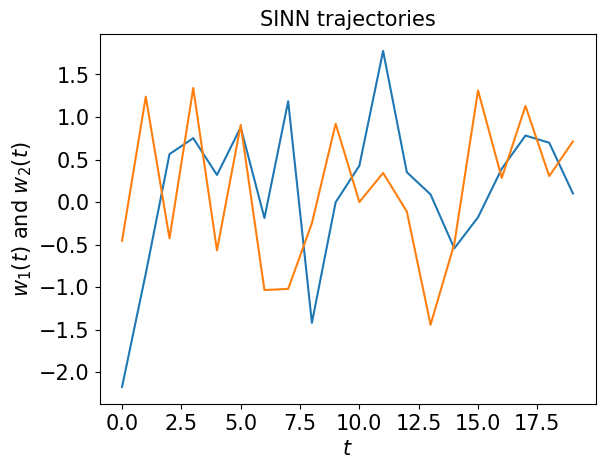

In [25]:
test1(model)

In [26]:
def test2(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
    acf_t=StatLoss.acf(target)
    corr_p1=acf_p.detach().cpu().numpy()
    corr_t1=acf_t.detach().cpu().numpy()
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p2=ccf_p.detach().cpu().numpy()
    corr_t2=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $w_1$',fontsize=15)    
    plt.plot(T, corr_t1[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $w_2$',fontsize=15)          
    plt.plot(T, corr_t1[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T[:50], corr_t2[0:50,:],'r')        # correlation function of the target 
    plt.plot(T[:50], corr_p2[0:50,:], 'b--')        # Correlation function after the training      # Correlation function after the training 
#     plt.plot(T, corr_t2[:,:],'r')        # correlation function of the target 
#     plt.plot(T, corr_p2[:,:], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylim(-0.05,0.05)

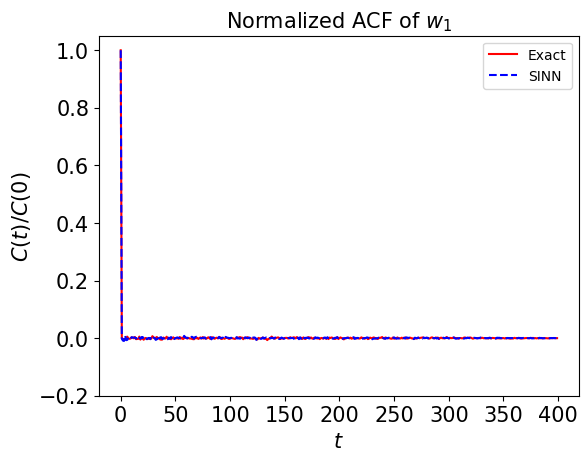

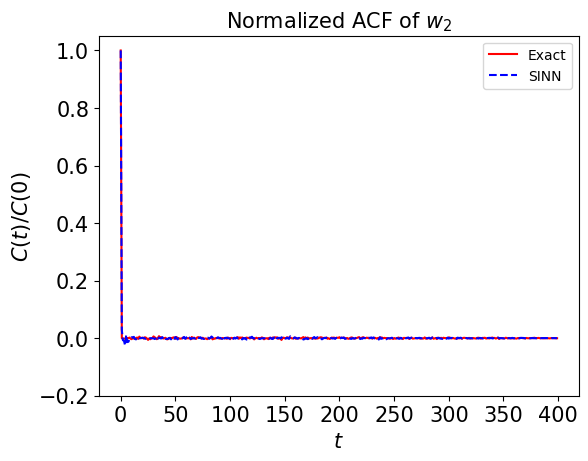

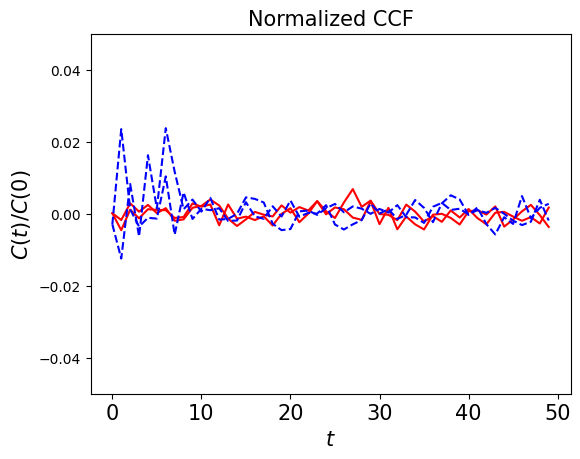

In [27]:
test2(model)

In [28]:
def test3(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 400, None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    rho_data2 =  StatLoss.gauss_kde2(target, -5, 5, 400, None).cpu()
    rho_prediction2 = StatLoss.gauss_kde2(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()


    x=np.linspace(-5, 5, 400)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_1$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_2$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_1$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_2$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,0],label=r'Exact PDF of $q_1+q_2$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,1],label=r'Exact PDF of $q_2-q_2$')    # target PDF
    plt.plot(x, rho_prediction2.numpy()[...,0], ':',label=r'PDF of the output $q_1+q_2$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,1], ':',label=r'PDF of the output $q_1-q_2$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

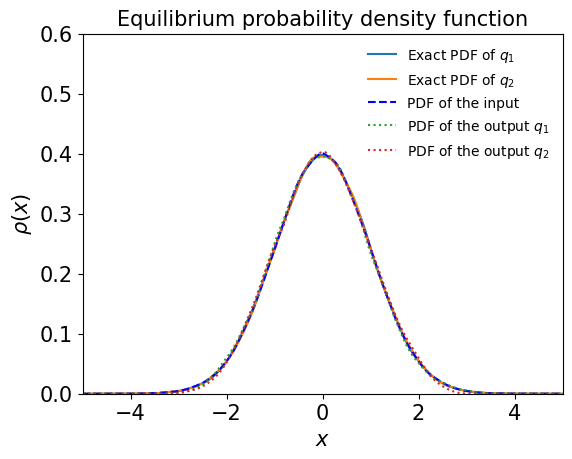

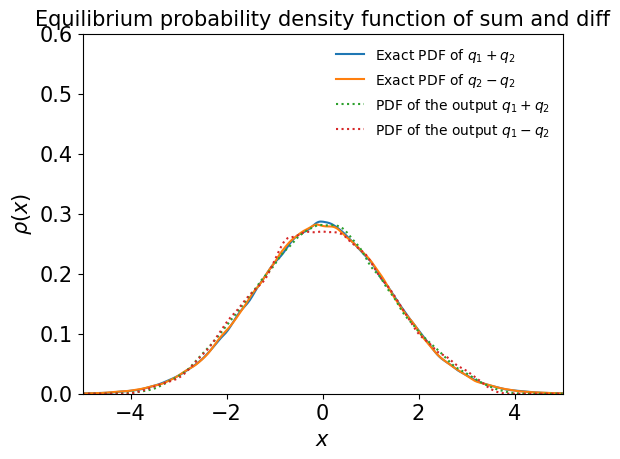

In [29]:
test3(model)

In [30]:
def test4(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $w_1^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $w_2^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()  

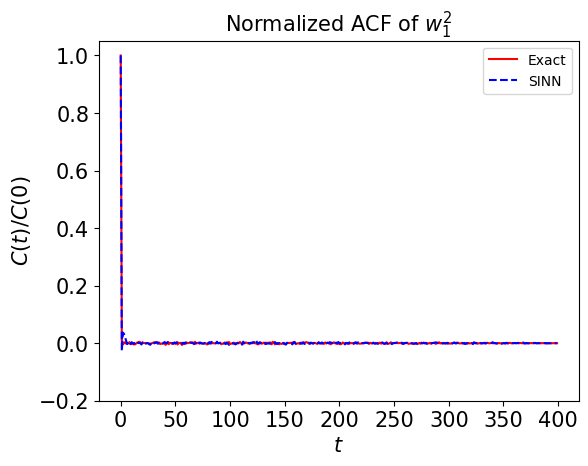

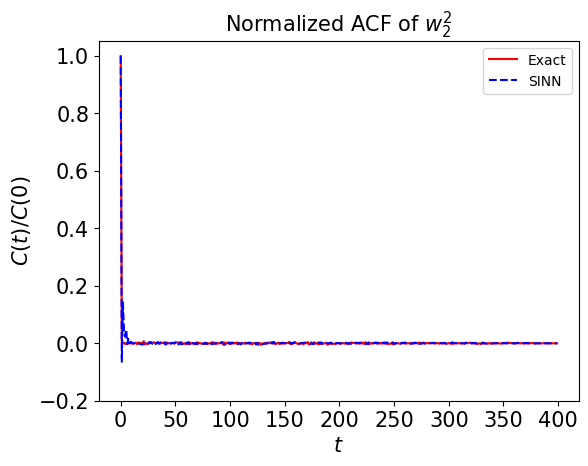

In [31]:
test4(model)

In [32]:
def test5(model):
    # Test 5: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    fig = plt.figure(0,figsize=(5, 5))
    plt.title("MD trajectories",fontsize=15) 
    plt.scatter(Traj[:,:,0], Traj[:,:,1])
    plt.xlabel(r'$w_1(t)$',fontsize=15)
    plt.ylabel(r'$w_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 
    plt.xlim(-5,5)
    plt.ylim(-5,5)


    fig = plt.figure(1,figsize=(5, 5))
    plt.title("SINN trajectories",fontsize=15)    
    plt.scatter(prediction[:,:,0],prediction[:,:,1])
    plt.xlabel(r'$w_1(t)$',fontsize=15)
    plt.ylabel(r'$w_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)   
    plt.xlim(-5,5)
    plt.ylim(-5,5)

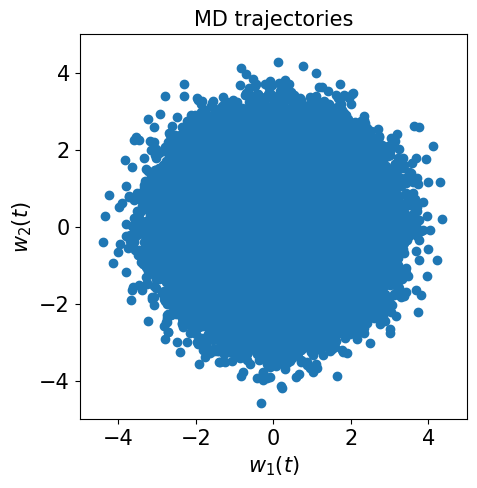

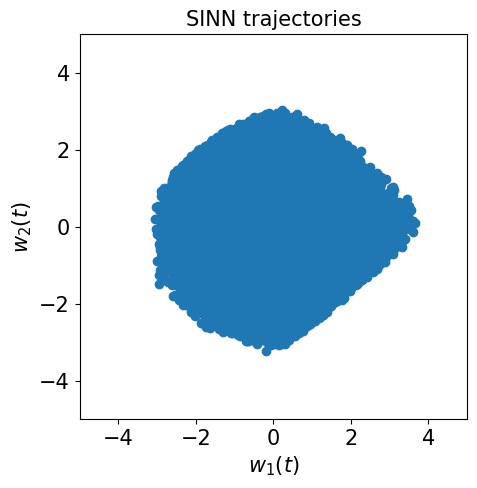

In [33]:
test5(model)

In [34]:
def test6(model):
    # Test 5: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    rho_data =  StatLoss.gauss_kde2D(target, -5, 5, 20, None).cpu()
    rho_prediction = StatLoss.gauss_kde2D(Pred[-sec_length:,:,:].detach(), -5, 5, 20,None).cpu()
    
    fig = plt.figure(0, figsize=(5, 5))
    plt.title("PDF Contours",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

    xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    axs[0]  = fig.gca()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    plt.contour(xx,yy,rho_data.numpy(),colors='r')
    plt.contour(xx,yy,rho_prediction.numpy(),colors='b',linestyles='dashed')

    plt.xlabel('w1')
    plt.ylabel('w2')

    
    
    fig = plt.figure(1,figsize=(5, 5))
    plt.title("MD trajectories",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

    xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_data.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_data.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')

    
    
    fig = plt.figure(2,figsize=(5, 5))
    plt.title("SINN output",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

    xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_prediction.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_prediction.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')

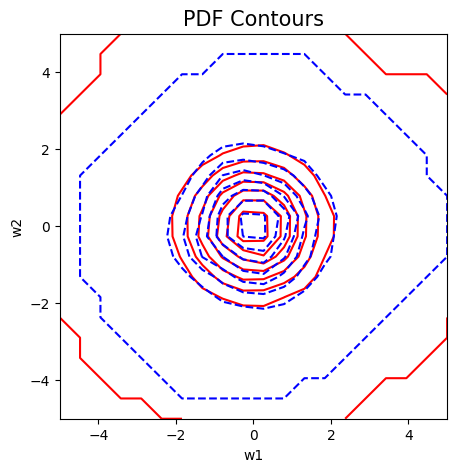

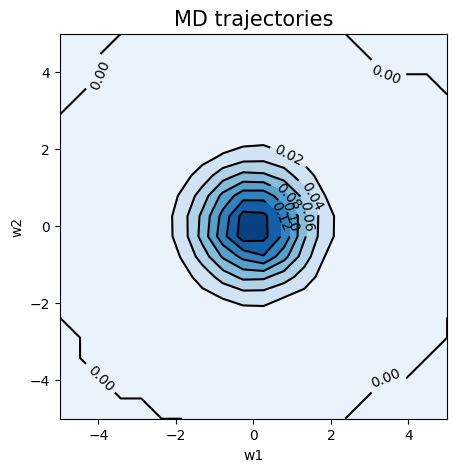

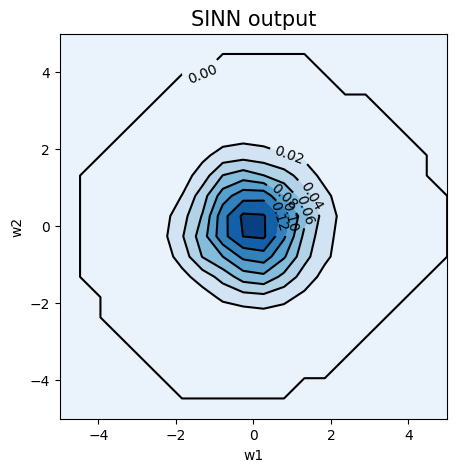

In [35]:
test6(model)

# 2 inputs

In [36]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


# Traj = Traj.astype(np.float32) 
# target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [37]:
### Defining SINN model
net = SINN(2, 10, 2, 2).to(device)
model = Model(net=net)

In [38]:
model.train()

[0]-th step loss: 0.5427, 0.5416, acf: 0.00310, ccf: 0.005098, pdf: 0.25776, pdf2: 0.27296, acf2: 0.00268
[50]-th step loss: 0.5070, 0.5044, acf: 0.00079, ccf: 0.000078, pdf: 0.25174, pdf2: 0.25120, acf2: 0.00057
[100]-th step loss: 0.1929, 0.1883, acf: 0.00314, ccf: 0.000041, pdf: 0.14706, pdf2: 0.03664, acf2: 0.00146
[150]-th step loss: 0.1402, 0.1400, acf: 0.00380, ccf: 0.000079, pdf: 0.12807, pdf2: 0.00617, acf2: 0.00188
[200]-th step loss: 0.1261, 0.1254, acf: 0.00267, ccf: 0.000153, pdf: 0.11688, pdf2: 0.00430, acf2: 0.00135
[250]-th step loss: 0.0453, 0.0438, acf: 0.00233, ccf: 0.000549, pdf: 0.03646, pdf2: 0.00341, acf2: 0.00110
[300]-th step loss: 0.0128, 0.0127, acf: 0.00204, ccf: 0.000433, pdf: 0.00775, pdf2: 0.00176, acf2: 0.00069
[350]-th step loss: 0.0073, 0.0072, acf: 0.00145, ccf: 0.000371, pdf: 0.00380, pdf2: 0.00121, acf2: 0.00040
[400]-th step loss: 0.0048, 0.0048, acf: 0.00104, ccf: 0.000312, pdf: 0.00236, pdf2: 0.00090, acf2: 0.00022
[450]-th step loss: 0.0034, 0.0

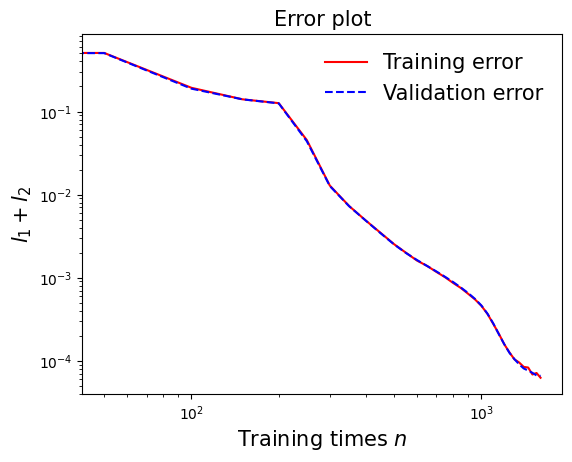

In [39]:
draw_loss(model)

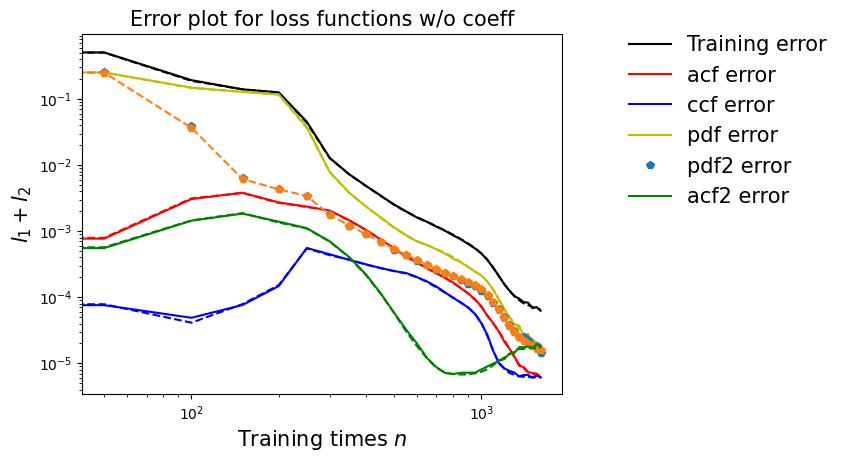

In [40]:
draw_errors(model)

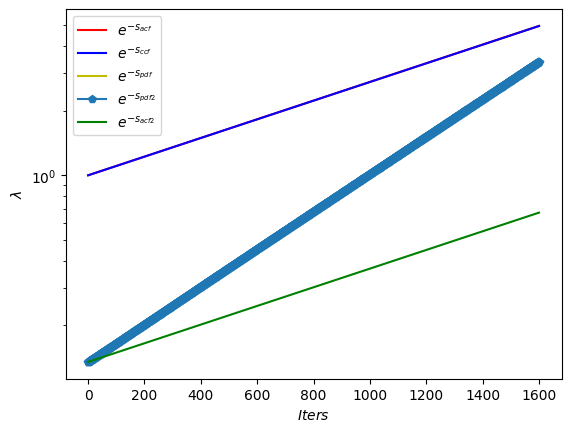

In [41]:
draw_epoch_w(model)

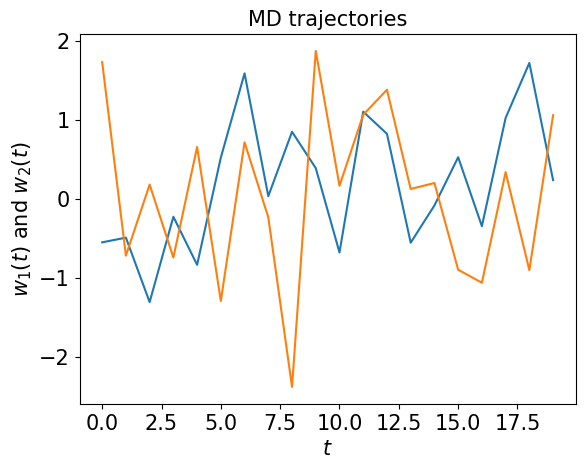

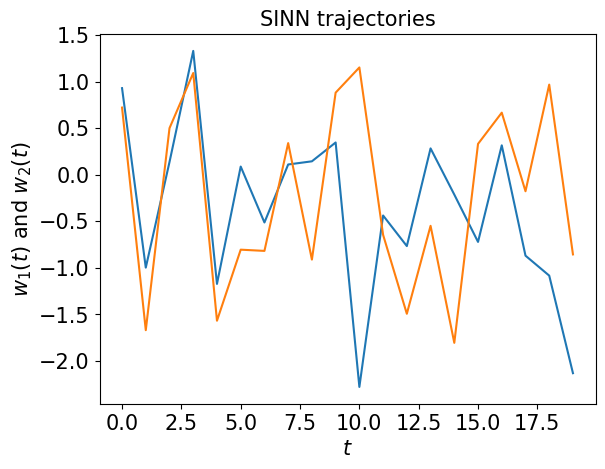

In [42]:
test1(model)

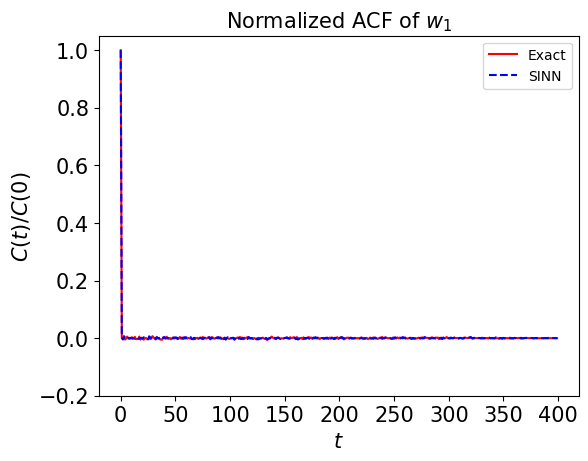

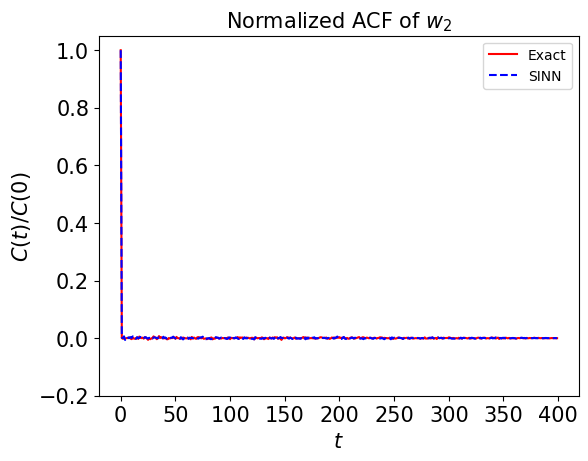

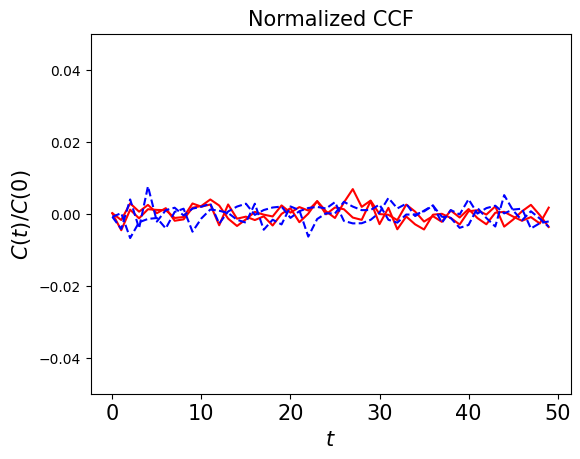

In [43]:
test2(model)

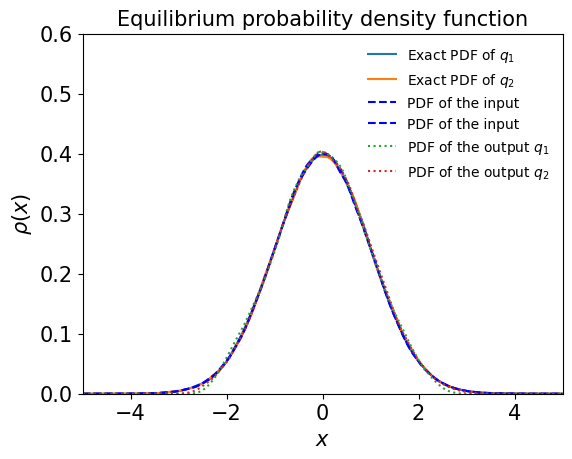

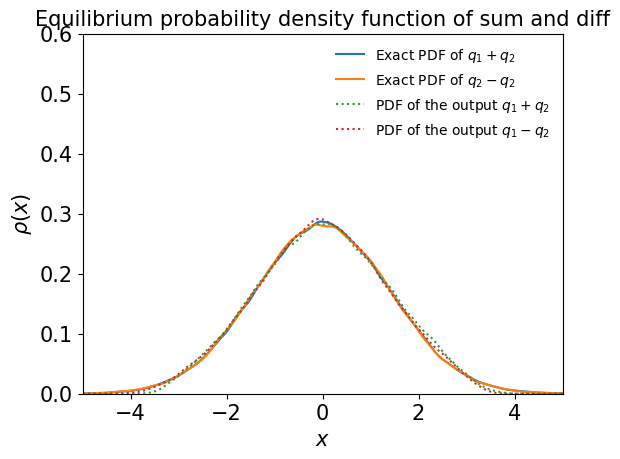

In [44]:
test3(model)

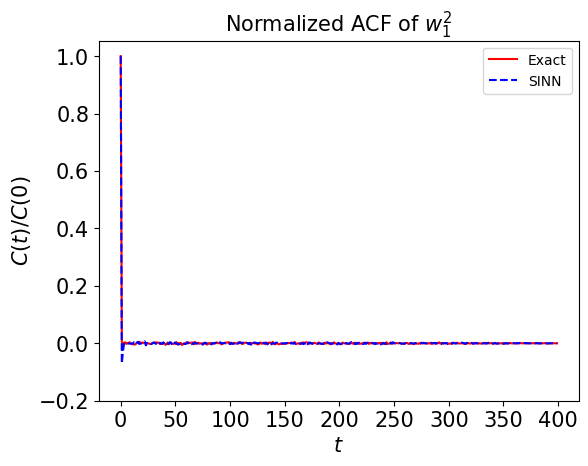

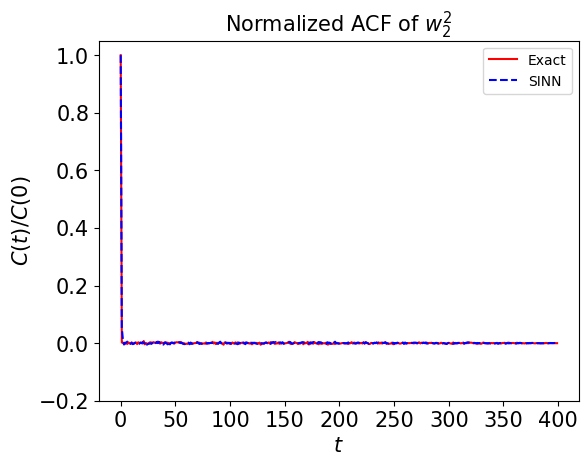

In [45]:
test4(model)

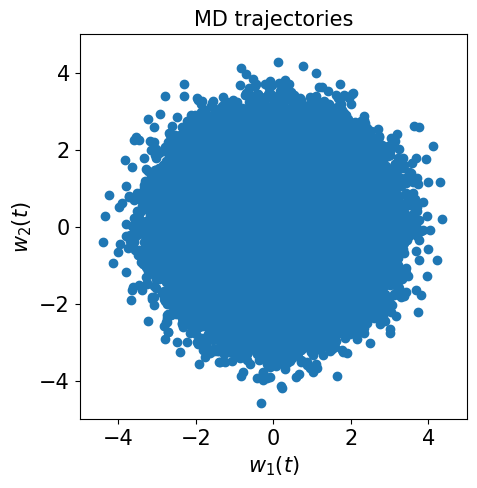

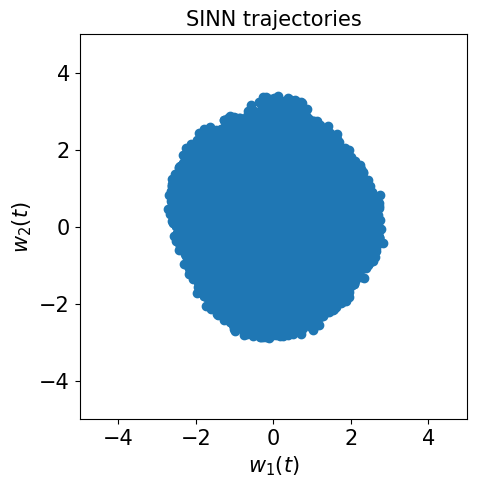

In [46]:
test5(model)

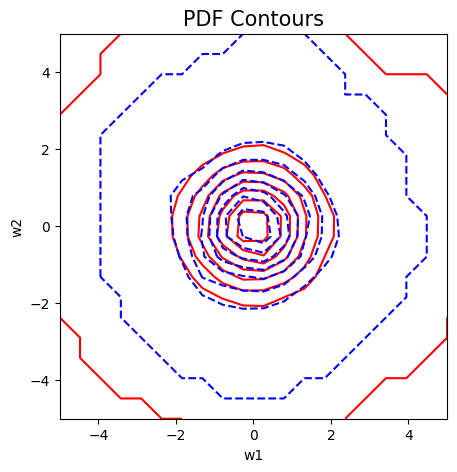

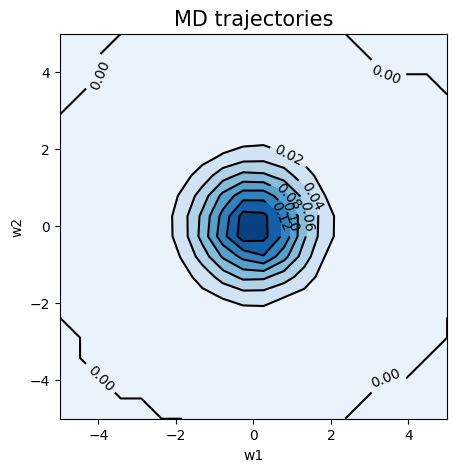

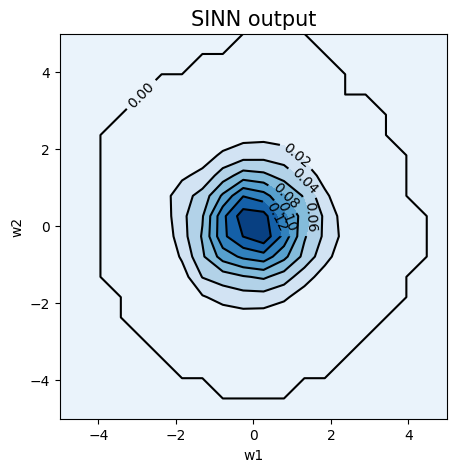

In [47]:
test6(model)

In [48]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,3*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 3)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 3), device=device)


# Traj = Traj.astype(np.float32) 
# target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 3]) torch.float32
The torch validation size is torch.Size([800, 400, 3]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [49]:
### Defining SINN model
net = SINN(3, 10, 2, 2).to(device)
model = Model(net=net)

In [50]:
model.train()

[0]-th step loss: 0.5305, 0.5297, acf: 0.00291, ccf: 0.000145, pdf: 0.25414, pdf2: 0.26974, acf2: 0.00280
[50]-th step loss: 0.3306, 0.3225, acf: 0.00310, ccf: 0.000072, pdf: 0.18496, pdf2: 0.13219, acf2: 0.00214
[100]-th step loss: 0.1632, 0.1630, acf: 0.00495, ccf: 0.000019, pdf: 0.13326, pdf2: 0.02118, acf2: 0.00353
[150]-th step loss: 0.1502, 0.1501, acf: 0.00334, ccf: 0.000017, pdf: 0.13058, pdf2: 0.01404, acf2: 0.00212
[200]-th step loss: 0.1422, 0.1420, acf: 0.00267, ccf: 0.000013, pdf: 0.12802, pdf2: 0.01000, acf2: 0.00131
[250]-th step loss: 0.0735, 0.0720, acf: 0.00390, ccf: 0.000175, pdf: 0.05181, pdf2: 0.01358, acf2: 0.00250
[300]-th step loss: 0.0448, 0.0446, acf: 0.00344, ccf: 0.000482, pdf: 0.02855, pdf2: 0.01025, acf2: 0.00184
[350]-th step loss: 0.0316, 0.0313, acf: 0.00287, ccf: 0.000793, pdf: 0.01868, pdf2: 0.00763, acf2: 0.00134
[400]-th step loss: 0.0213, 0.0211, acf: 0.00247, ccf: 0.000908, pdf: 0.01097, pdf2: 0.00568, acf2: 0.00109
[450]-th step loss: 0.0142, 0.0

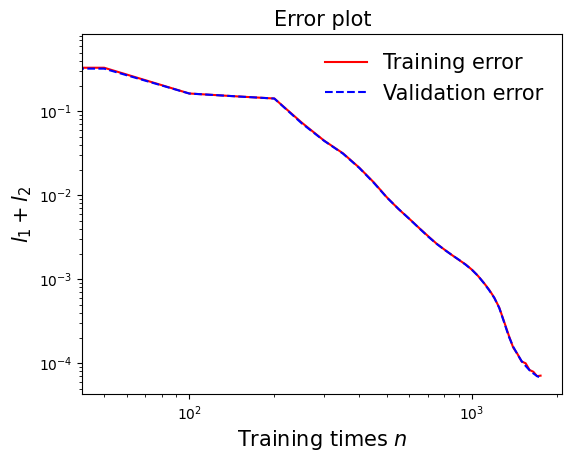

In [51]:
draw_loss(model)

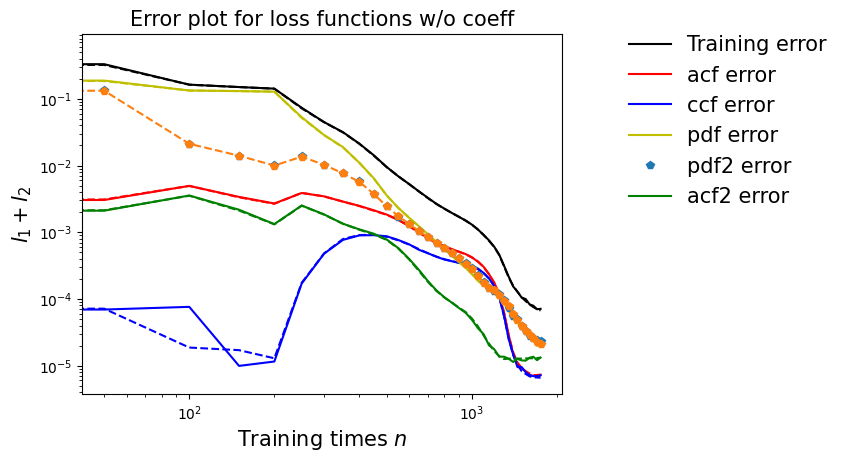

In [52]:
draw_errors(model)

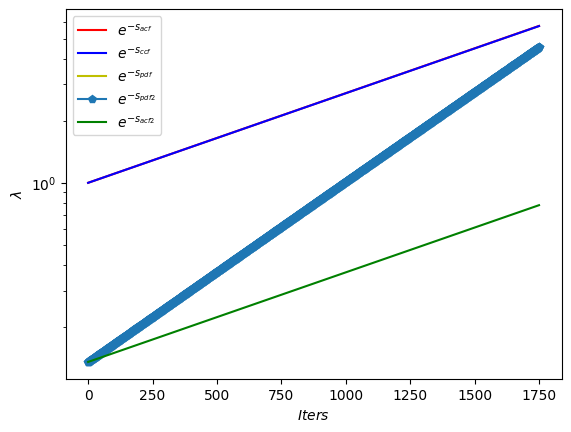

In [53]:
draw_epoch_w(model)

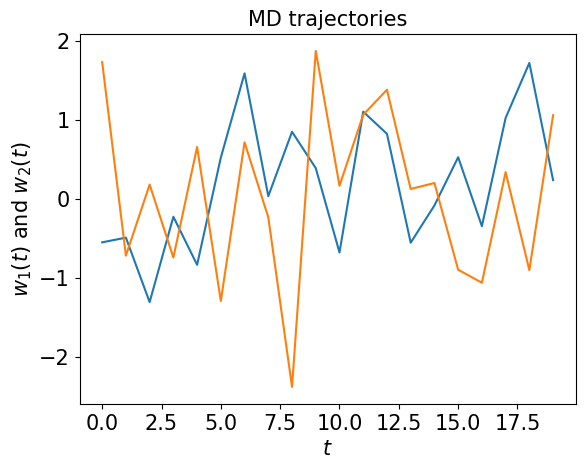

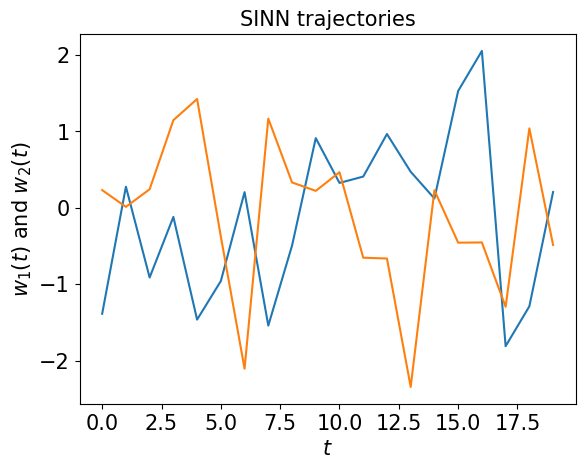

In [54]:
test1(model)

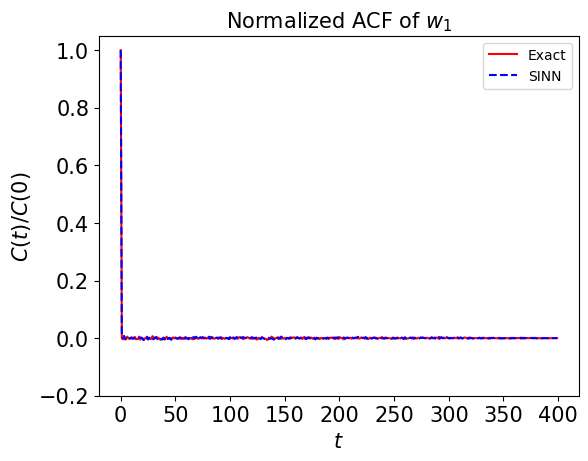

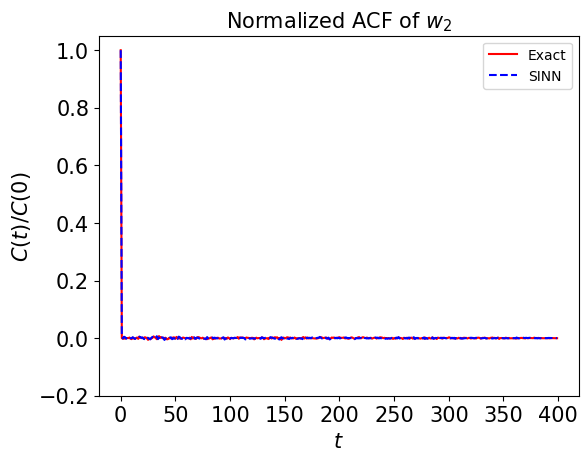

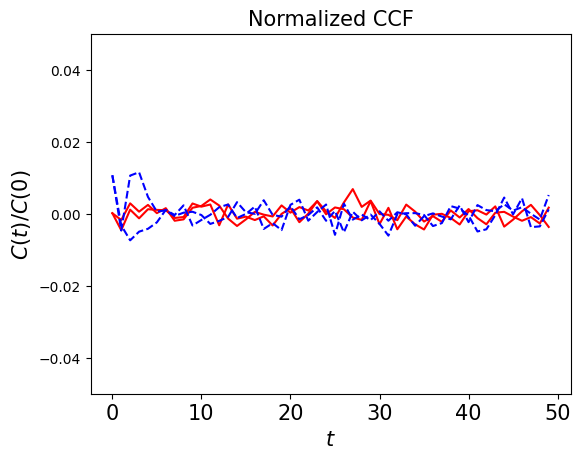

In [55]:
test2(model)

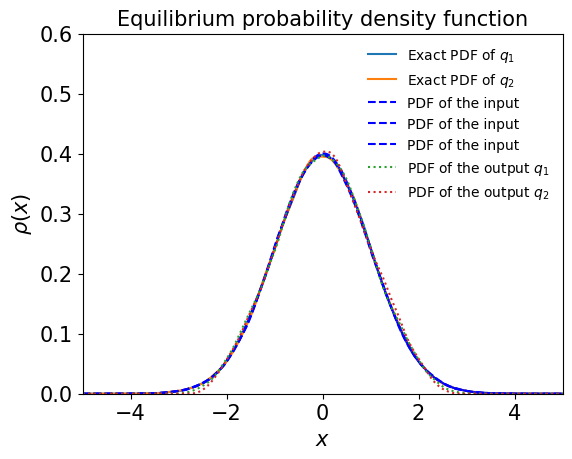

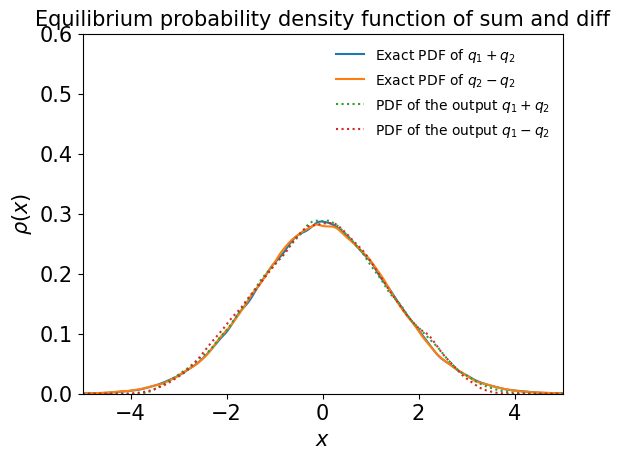

In [56]:
test3(model)

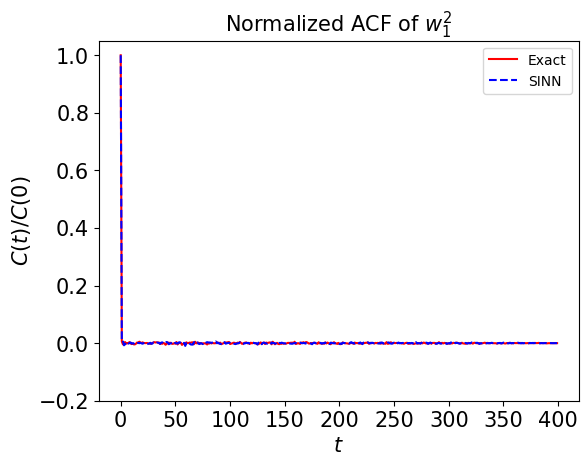

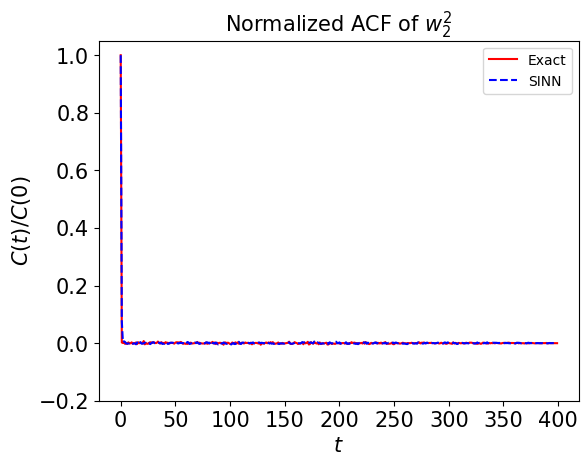

In [57]:
test4(model)

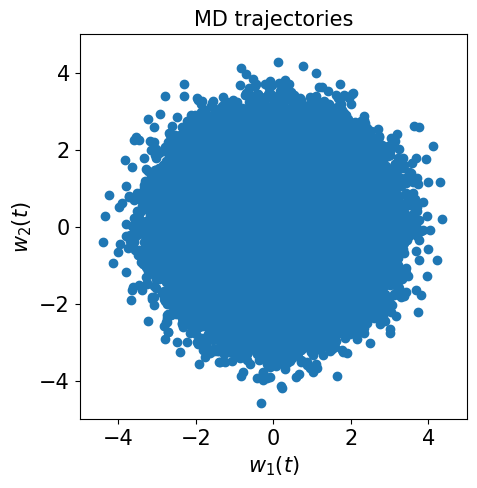

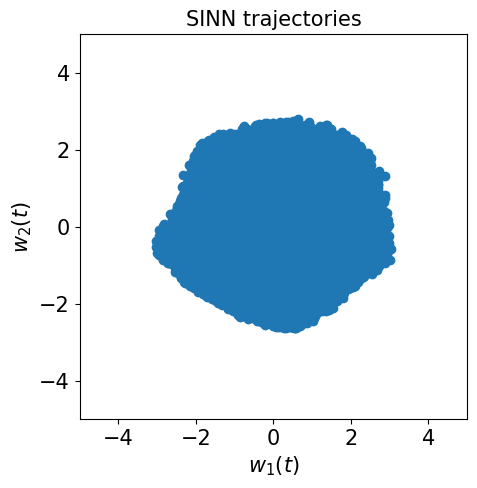

In [58]:
test5(model)

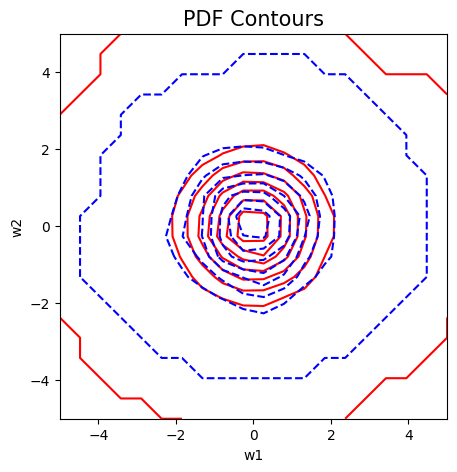

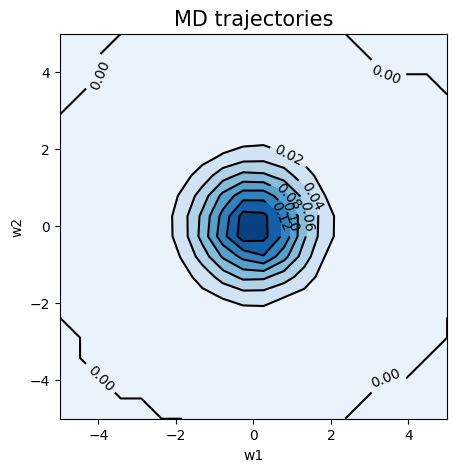

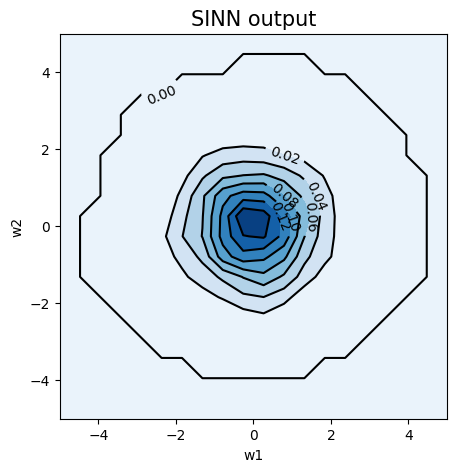

In [59]:
test6(model)